Reconstruct static polygons...
Find static polygons...
Group by polygons...
Reverse reconstruct points...
Sample present-day grid...
(65341,)
Write reconstructed points...


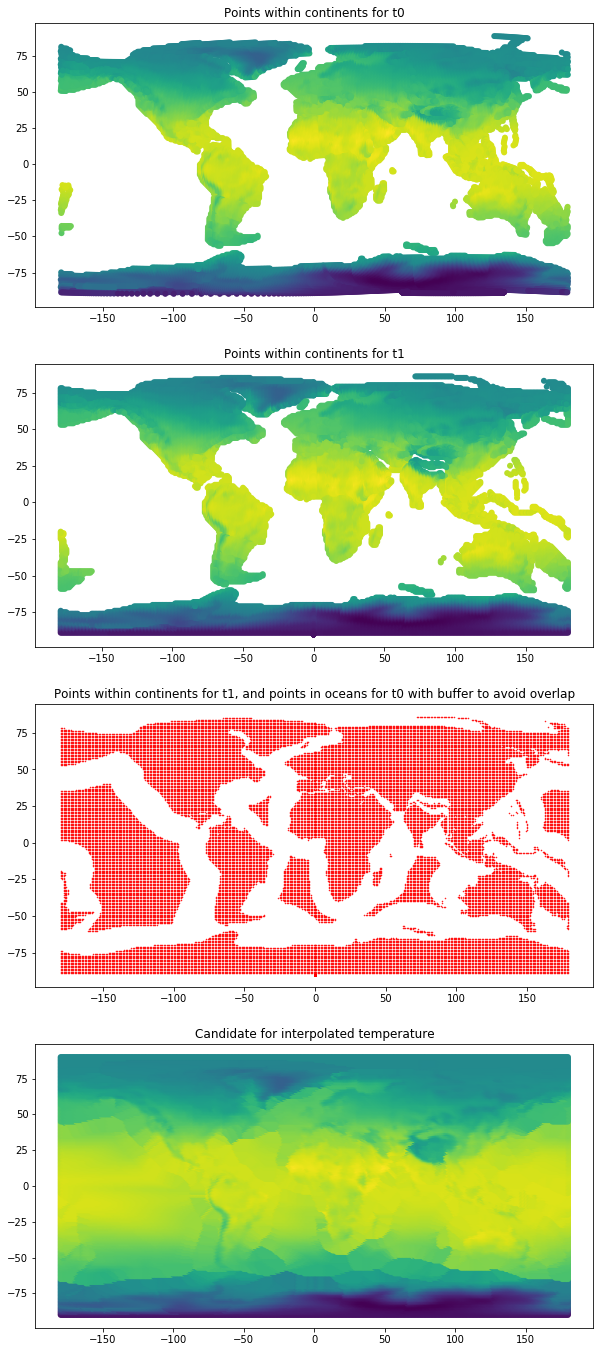

0

In [5]:
import pygplates
import numpy as np
import matplotlib.pyplot as plt
from reconstruct_atom_rasters import *
from proximity_query import *
import points_spatial_tree
from sphere_tools import sampleOnSphere

%matplotlib inline

rotation_model=pygplates.RotationModel('./data/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot' )
static_polygon_features = pygplates.FeatureCollection('./data/ContinentalPolygons/Matthews_etal_GPC_2016_ContinentalPolygons.gpmlz' )

ascii_grid_file = '../../data/SurfaceTemperature_NASA.xyz'

time_of_existing_grid = 0.
time_for_new_grid = 20.
buffer_degrees = 15.

tmpX,tmpY = np.meshgrid(np.arange(-180.,181.,1.),np.arange(-90.,91.,1.)) 
tmpX = tmpX.flatten()
tmpY = tmpY.flatten()

points,data_array = xyzfile_to_spatial_tree_of_points(ascii_grid_file)

spatial_tree_of_uniform_recon_points = points_spatial_tree.PointsSpatialTree(points)



##############
# Continents
##############

# reconstruct points within continent polygons from t_n+time_step to t_n
recon_point_lons,recon_point_lats,point_lons,point_lats = reconstruct_raster_stage(static_polygon_features, 
                                                                                   rotation_model,
                                                                                   time_of_existing_grid,
                                                                                   time_for_new_grid,
                                                                                   points, 
                                                                                   spatial_tree_of_uniform_recon_points)


# interpolate the values from the grid at t_n onto the unreconstructed points (where we 
# already know the point locations at t_n+time_step)
d,l = sampleOnSphere(data_array[:,1],
                     data_array[:,0],
                     data_array[:,2],
                     np.hstack(point_lats),
                     np.hstack(point_lons),n=4)

interp_land_temp = data_array[:,2].ravel()[l]


##########
# Oceans
##########

# find points that are not within, and actually not close to (defined by some buffer distance) 
# the continent polygons at t_n. This results in a set of points far from continents at t_n,
# but there may be some overlap with points within continents at t_n+time_step if the time step
# is large and/or the continents are moving quickly
pnp_test = run_grid_pnp(time_of_existing_grid,
                        points,
                        spatial_tree_of_uniform_recon_points,
                        static_polygon_features, 
                        rotation_model, 
                        np.radians(buffer_degrees))
        
ocean_index = np.where(np.array(pnp_test)==0)


##########################
# Merged Land and Oceans
##########################

merged_lons = np.hstack((np.hstack(recon_point_lons),data_array[ocean_index,0].flatten()))
merged_lats = np.hstack((np.hstack(recon_point_lats),data_array[ocean_index,1].flatten()))
merged_temp = np.hstack((interp_land_temp,data_array[ocean_index,2].flatten()))

merged_lons = ((merged_lons+180) % 360) - 180

d,l = sampleOnSphere(merged_lats,
                     merged_lons,
                     merged_temp,
                     tmpY,
                     tmpX,n=4)

interp_total_temp = merged_temp.ravel()[l]

print interp_total_temp.shape
print 'Write reconstructed points...'


plt.figure(figsize=(10,24))
#plt.plot(np.hstack(recon_point_lons),np.hstack(recon_point_lats),'b.')
#plt.plot(np.hstack(point_lons),np.hstack(point_lats),'r.')
plt.subplot(411)
plt.scatter(np.hstack(point_lons),np.hstack(point_lats),c=interp_land_temp,edgecolors='')
plt.title('Points within continents for t0')
plt.subplot(412)
plt.scatter(np.hstack(recon_point_lons),np.hstack(recon_point_lats),c=interp_land_temp,edgecolors='')
plt.title('Points within continents for t1')
plt.subplot(413)
plt.plot(merged_lons,merged_lats,'r.',markersize=1)
plt.title('Points within continents for t1, and points in oceans for t0 with buffer to avoid overlap')
plt.subplot(414)
plt.scatter(tmpX,tmpY,c=interp_total_temp,edgecolors='')
plt.title('Candidate for interpolated temperature')
plt.show()


# Write out an xyz file for each scalar type - each file contains (lon, lat, scalar).
write_xyz_file('tmp.xyz', zip(tmpX, tmpY, interp_total_temp))
write_xyz_file('buffer_tmp.xyz', zip(merged_lons, merged_lats, merged_temp))
write_xyz_file('buffer_land_tmp.xyz', zip(np.hstack(recon_point_lons), 
                                          np.hstack(recon_point_lats), 
                                          interp_land_temp))
write_xyz_file('buffer_ocean_tmp.xyz', zip(data_array[ocean_index,0].flatten(), 
                                           data_array[ocean_index,1].flatten(), 
                                           data_array[ocean_index,2].flatten()))


# create a gmt grid that fills gaps using nearest-neighbour interpolation from python
# (but gaps are filled by interpolation from neighbouring continents as well as oceans)
os.system('/opt/gmt5/bin/gmt xyz2grd tmp.xyz -Gnearest_neighbour_fill_the_gap.nc -Rd -I%0.8f' % 1.)

# create a gmt grid that fills gaps using surface 
# (but gaps are filled by interpolation from neighbouring continents as well as oceans)
os.system('/opt/gmt5/bin/gmt surface buffer_tmp.xyz -Ggmt_surface_fill_the_gap.nc -Rd -I%0.8f -T0.1' % 1.)

# create a seperate gmt grids for reconstructed land (with nan's in oceans) and oceans (using
# surface to fill gaps everwhere). Then blend together with continents taking precedence
# BUT: gaps within continent will look funny due to filling from oceans (e.g. within Himalayas)
os.system('/opt/gmt5/bin/gmt xyz2grd buffer_land_tmp.xyz -Gbuffer_land_tmp.nc -Rd -I%0.8f' % 1.)
os.system('/opt/gmt5/bin/gmt surface buffer_ocean_tmp.xyz -Gfill_ocean_tmp.nc -Rd -I%0.8f -T0.1' % 1.)
os.system('/opt/gmt5/bin/gmt grdblend buffer_land_tmp.nc fill_ocean_tmp.nc -Ggmt_grdblend_clobber.nc -Cf -Rd -I%0.8f' % 1.)
#os.system('/opt/gmt5/bin/gmt grdmath buffer_land_tmp.nc fill_ocean_tmp.nc OR = gmt_grdblend_clobber.nc')





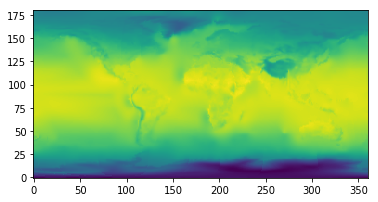

In [2]:
from netCDF4 import Dataset

tsurf = Dataset('./gmt_surface_fill_the_gap.nc')

plt.imshow(tsurf.variables['z'],origin='lower')


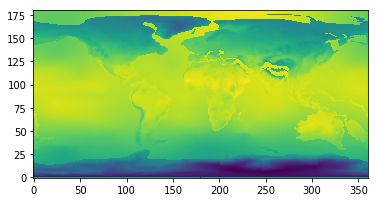

In [3]:
tblend = Dataset('./gmt_grdblend_clobber.nc')

plt.imshow(tblend.variables['z'],origin='lower')


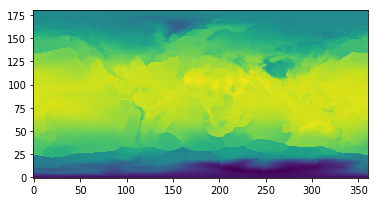

In [4]:
from netCDF4 import Dataset

tsurf = Dataset('./nearest_neighbour_fill_the_gap.nc')

plt.imshow(tsurf.variables['z'],origin='lower')
